Prediction models of human plasma protein binding rate and oral bioavailability
--

In [ ]:
!pip install PyTDC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 930.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 8.3 M

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from tdc.single_pred import ADME
data = ADME(name = 'Bioavailability_Ma')
split = data.get_split()

Downloading...
100%|██████████| 43.7k/43.7k [00:00<00:00, 785kiB/s]
Loading...
Done!


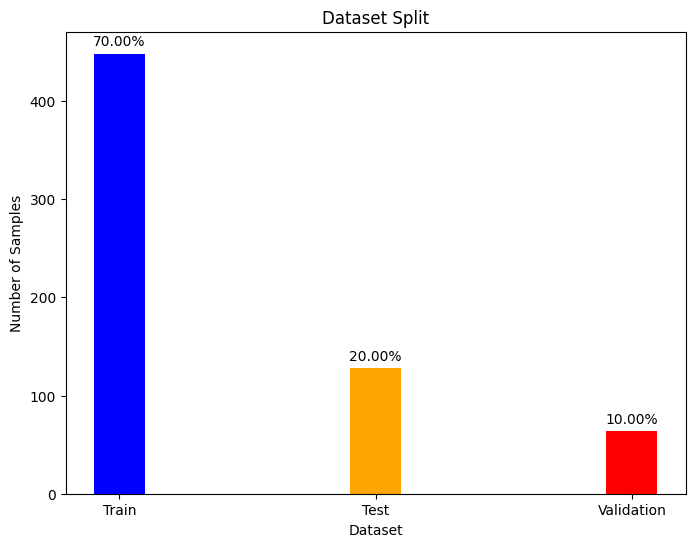

In [ ]:
# Visualize the split

train_size = len(split['train'])
valid_size = len(split['valid'])
test_size = len(split['test'])

label = ['Train', 'Test', 'Validation']
sizes = [train_size, test_size, valid_size]

total_size = train_size + valid_size + test_size
percentage = [size / total_size * 100 for size in sizes]


plt.figure(figsize=(8, 6))
bins = plt.bar(label, sizes, color=['blue', 'orange', 'red'], width=0.2)
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Dataset Split')
for bin, percentage in zip(bins, percentage):
    plt.text(bin.get_x() + bin.get_width() / 2, bin.get_height() + 5, f'{percentage:.2f}%', ha='center', va='bottom')
plt.show()

Feature Generation
---

| Descriptor | Description | Category |
|------------|-------------|----------|
| Mv         | Mean atomic van der Waals volume (scaled on carbon atom) | Constitutional descriptors |
| MS         | Mean electrotopological state | Constitutional descriptors |
| nAT        | Number of atoms | Constitutional descriptors |
| nS         | Number of sulfur atoms | Constitutional descriptors |
| ARR        | Aromatic ratio | Constitutional descriptors |
| PJI2       | 2D Petitjean shape index | Topological descriptors |
| PW2        | Path/walk 2-Randic shape index | Topological descriptors |
| ZM2v       | Second Zagreb index by valence vertex degrees | Topological descriptors |
| SRW05      | Self-returning walk count of order 05 | Walk and path counts |
| X4Av       | Average valence connectivity index chi-4 | Connectivity indices |
| J3D        | 3D-Balaban index | Geometrical descriptors |
| RDF020m    | Radial distribution function − 2.0/weighted by atomic masses | RDF descriptors |
| RDF035m    | Radial distribution function − 3.5/weighted by atomic masses | RDF descriptors |
| RDF075m    | Radial distribution function − 7.5/weighted by atomic masses | RDF descriptors |
| C-001      | CH3R/CH4 | Atom-centred fragments |
| C-003      | CHR3 | Atom-centred fragments |
| C-011      | CR3X | Atom-centred fragments |
| C-017      | CR2 | Atom-centred fragments |
| H-047      | H attached to C1(sp3)/C0(sp2) | Atom-centred fragments |
| H-048      | H attached to C2(sp3)/C1(sp2)/C0(sp) | Atom-centred fragments |
| H-049      | H attached to C3(sp3)/C2(sp2)/C3(sp2)/C3(sp) | Atom-centred fragments |
| H-052      | H attached to C0(sp3) with 1X attached to next C | Atom-centred fragments |
| S-107      | R2S/RS-SR | Atom-centred fragments |
| EEig03x    | Eigenvalue 03 from edge adj. matrix weighted by edge degrees | Edge adjacency indices |
| ESpm01d    | Spectral moment 01 from edge adj. matrix weighted by dipole moments | Edge adjacency indices |
| ALOGP2     | Squared Ghose–Crippen octanol–water partition coefficient (log P2) | Molecular properties |
| TPSA(Tot)  | Topological polar surface area using N, O, S, P polar contributions | Molecular properties |
| nCconj     | Number of non-aromatic conjugated C(sp2) | Functional group counts |
| nRCONHR    | Number of secondary amides (aliphatic) | Functional group counts |


PPBR

-----

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import EState
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import Crippen
from rdkit.Chem import QED
import numpy as np

# Mean atomic van der Waals volume (scaled on carbon atom)
def mv(drug):
    m = Chem.MolFromSmiles(drug)
    carbon_scale = (4/3) * np.pi * Chem.GetPeriodicTable().GetRvdw(6)
    total = 0.0
    for i in m.GetAtoms():
      vol = (4/3) * np.pi * Chem.GetPeriodicTable().GetRvdw(i.GetAtomicNum())
      vol = vol / carbon_scale
      total += vol
    vol = total / len(m.GetAtoms())
    return vol

# Mean electrotopological state
def ms(drug):
    m = Chem.MolFromSmiles(drug)
    estates = EState.EStateIndices(m)
    return np.mean(estates)

# Number of atoms
def nat(drug):
    m = Chem.MolFromSmiles(drug)
    return len(m.GetAtoms())

# Number of sulfur atoms
def ns(drug):
    m = Chem.MolFromSmiles(drug)
    count = 0
    for i in m.GetAtoms():
        if i.GetAtomicNum() == 16:
            count += 1
    return count

# Aromatic ratio
def arr(drug):
    m = Chem.MolFromSmiles(drug)
    aromatic_count = 0
    for i in m.GetAtoms():
        if i.GetIsAromatic():
            aromatic_count += 1
    return aromatic_count / len(m.GetAtoms())

# Average valence connectivity index chi-4
def x4av(drug):
    m = Chem.MolFromSmiles(drug)
    return rdMolDescriptors.CalcChi4v(m)

# Spectral moment 01 from edge adj. matrix weighted by dipole moments
def espm01d(drug):
  m = Chem.MolFromSmiles(drug)
  electronegativities = {
        'H': 2.20, 'C': 2.55, 'N': 3.04, 'O': 3.44, 'F': 3.98,
        'P': 2.19, 'S': 2.58, 'Cl': 3.16, 'Br': 2.96, 'I': 2.66
    }
  num_atoms = m.GetNumAtoms()
  dipole_moments = []
  for atom in m.GetAtoms():
    symbol = atom.GetSymbol()
    electronegativity = electronegativities.get(symbol, 0.0)
    dipole_moments.append(electronegativity)
  edge_adjacency_matrix = np.zeros((num_atoms, num_atoms))
  for bond in m.GetBonds():
    i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    edge_adjacency_matrix[i, j] = edge_adjacency_matrix[j, i] = 1
  eigenvalues = eigvalsh(edge_adjacency_matrix)
  weighted_eigenvalues = eigenvalues * np.array(dipole_moments)
  espm01d = np.sum(weighted_eigenvalues)
  # print("ESpm01d:",espm01d)
  return espm01d

# Squared Ghose–Crippen octanol–water partition coefficient (log P^2)
def alogp2(drug):
    m = Chem.MolFromSmiles(drug)
    return Crippen.MolLogP(m) ** 2

# Topological polar surface area using N, O, S, P polar contributions
def tpsa(drug):
    m = Chem.MolFromSmiles(drug)
    return rdMolDescriptors.CalcTPSA(m)

# Number of non-aromatic conjugated C(sp^2)
def nCconj(drug):
    m = Chem.MolFromSmiles(drug)
    count = 0
    for i in m.GetAtoms():
        if i.GetHybridization() == Chem.rdchem.HybridizationType.SP2 and not i.GetIsAromatic():
            count += 1
    return count

# Number of secondary amides (aliphatic)
def nRCONHR(drug):
    m = Chem.MolFromSmiles(drug)
    count = 0
    for bond in m.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        if atom1.GetSymbol() == 'C' and atom2.GetSymbol() == 'O' and atom2.GetFormalCharge() == 0:
            neighbors = [a.GetSymbol() for a in atom1.GetNeighbors()]
            if 'N' in neighbors:
                count += 1
    return count

BIO

----

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import EState
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import Crippen
from rdkit.Chem import QED
import numpy as np
from numpy.linalg import eigvals
from itertools import combinations
from numpy.linalg import eigvalsh
from scipy.linalg import eigvalsh

# Molecular weight
def MW(drug):
  m = Chem.MolFromSmiles(drug)
  # print("MW:", Descriptors.MolWt(m))
  return Descriptors.MolWt(m)

# Mean electrotopological state
def Ms(drug):
  m = Chem.MolFromSmiles(drug)
  estates = EState.EStateIndices(m)
  # print("Ms:", np.mean(estates))
  return np.mean(estates)

# number of 5 membered rings
def nR05(drug):
  m = Chem.MolFromSmiles(drug)
  # print("nR05:", len(Chem.GetSSSR(m)))
  return len(Chem.GetSSSR(m))

# 2-Path Kier alpha-modified shape index
def S2K(drug):
    m = Chem.MolFromSmiles(drug)
    kier_alpha = 0.5
    adjacency_matrix = Chem.GetAdjacencyMatrix(m)
    eigenvalues = np.linalg.eigvalsh(adjacency_matrix)
    kasi = sum(np.exp(-kier_alpha * eigenvalues))
    two_path_extension = 0
    num_atoms = m.GetNumAtoms()
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            bond = m.GetBondBetweenAtoms(i, j)
            if bond is not None:
                bond_order = bond.GetBondTypeAsDouble()
                two_path_extension += np.exp(-kier_alpha * bond_order)
    twopkasi = kasi + two_path_extension
    # print("S2K:", twopkasi)
    return twopkasi

#	First Zagreb index by valence vertex degrees
def ZM1V(drug):
  m = Chem.MolFromSmiles(drug)
  valence_degrees = [atom.GetDegree() for atom in m.GetAtoms()]
  M1 = sum(deg**2 for deg in valence_degrees)
  # print("ZM1V:", M1)
  return M1

#	Kier benzene-likeliness index
def BLI(drug):
  m = Chem.MolFromSmiles(drug)
  num_carbon_atoms = len([atom for atom in m.GetAtoms() if atom.GetAtomicNum() == 6])
  num_cc_bonds = len([bond for bond in m.GetBonds() if bond.GetBondTypeAsDouble() == 1])
  num_double_bonds = len([bond for bond in m.GetBonds() if bond.GetBondTypeAsDouble() == 2])
  bli = 1.6 * num_carbon_atoms - 0.4 * num_cc_bonds - 0.6 * num_double_bonds
  # print("BLI:", bli)
  return bli

# Second Mohar index TI2
def TI2(drug):
  m = Chem.MolFromSmiles(drug)
  num_atoms = m.GetNumAtoms()
  num_bonds = m.GetNumBonds()
  sum_valence_squares = sum(atom.GetTotalValence()**2 for atom in m.GetAtoms())
  sum_degree_squares = sum(bond.GetBeginAtom().GetTotalDegree()**2 + bond.GetEndAtom().GetTotalDegree()**2 for bond in m.GetBonds())
  TI2 = sum_valence_squares - sum_degree_squares
  # print("TI2:",TI2)
  return TI2

# D/Dr11	Distance/detour ring index of order 11
def Dr11(drug):
    m = Chem.MolFromSmiles(drug)
    num_vertices = m.GetAtoms()
    pairs = combinations(num_vertices, 2)
    eleven_apart_pairs = [(u, v) for (u, v) in pairs if len(Chem.GetShortestPath(m, u.GetIdx(), v.GetIdx())) == 11]
    dr11 = 0
    for u, v in eleven_apart_pairs:
        shortest_path_length = len(Chem.GetShortestPath(m, u.GetIdx(), v.GetIdx()))
        actual_path_length = shortest_path_length + 11
        detour = actual_path_length - shortest_path_length
        dr11 += detour
    # print("dr11:",dr11)
    return dr11

# Average connectivity index chi-1
def X1A(drug):
  m = Chem.MolFromSmiles(drug)
  num_atoms = m.GetNumAtoms()
  sum_degrees = sum(atom.GetDegree() for atom in m.GetAtoms())
  x1A = (sum_degrees / num_atoms) - 1
  # print("X1A:", x1A)
  return x1A

# Average valence connectivity index chi-0
def X0Av(drug):
  m = Chem.MolFromSmiles(drug)
  num_atoms = m.GetNumAtoms()
  sum_degrees = sum(atom.GetDegree() for atom in m.GetAtoms())
  x0Av = sum_degrees / num_atoms
  # print("X0Av:",x0Av)
  return x0Av

# Valence connectivity index chi-3
def X3v(drug):
  m = Chem.MolFromSmiles(drug)
  num_atoms = m.GetNumAtoms()
  x3v = sum(atom.GetDegree() * (atom.GetDegree() - 1) * (atom.GetDegree() - 2) / 6 for atom in m.GetAtoms())
  # print("X3V:", x3v)
  return x3v

# Molecular walk count of order 02 (Walk and path counts)
def MWC02(drug):
  m = Chem.MolFromSmiles(drug)
  mwc02 = 0
  num_atoms = m.GetNumAtoms()
  for i in range(num_atoms):
    for j in range(i+1, num_atoms):
      if m.GetBondBetweenAtoms(i, j) is not None:
        mwc02 += 1
  # print("MWCO2:",mwc02)
  return mwc02

# Spectral moment 01 from edge adj. matrix weighted by dipole moments
def ESpm01d(drug):
  m = Chem.MolFromSmiles(drug)
  electronegativities = {
        'H': 2.20, 'C': 2.55, 'N': 3.04, 'O': 3.44, 'F': 3.98,
        'P': 2.19, 'S': 2.58, 'Cl': 3.16, 'Br': 2.96, 'I': 2.66
    }
  num_atoms = m.GetNumAtoms()
  dipole_moments = []
  for atom in m.GetAtoms():
    symbol = atom.GetSymbol()
    electronegativity = electronegativities.get(symbol, 0.0)
    dipole_moments.append(electronegativity)
  edge_adjacency_matrix = np.zeros((num_atoms, num_atoms))
  for bond in m.GetBonds():
    i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    edge_adjacency_matrix[i, j] = edge_adjacency_matrix[j, i] = 1
  eigenvalues = eigvalsh(edge_adjacency_matrix)
  weighted_eigenvalues = eigenvalues * np.array(dipole_moments)
  espm01d = np.sum(weighted_eigenvalues)
  # print("ESpm01d:",espm01d)
  return espm01d

# Moriguchi octanol–water partition coefficient
def MLOGP(drug):
  m = Chem.MolFromSmiles(drug)
  m_logp = Crippen.MolLogP(m)
  # print("MLOGP:",m_logp)
  return m_logp

# Number of non-aromatic conjugated
def nCconj(drug):
  m = Chem.MolFromSmiles(drug)
  count = 0
  for i in m.GetAtoms():
    if i.GetHybridization() == Chem.rdchem.HybridizationType.SP2 and not i.GetIsAromatic():
      count += 1
  # print("nCconj:", count)
  return count

# Lipinski's rule
def lipinski(drug):
    m = Chem.MolFromSmiles(drug)
    properties = QED.properties(m)
    count = 0
    if properties.MW <= 500:
        count += 1
    if properties.ALOGP <= 5:
        count += 1
    if properties.HBD <= 5:
        count += 1
    if properties.HBA <= 10:
        count += 1
    return count

Feature Aggregation
---

PPBR

------

In [ ]:
def feature_gen_ppbr(drug_sequences):
  features = []
  for drug in drug_sequences:
      mv_out = mv(drug)
      ms_out = ms(drug)
      nat_out = nat(drug)
      ns_out = ns(drug)
      arr_out = arr(drug)
      x4av_out = x4av(drug)
      espm01d_out = espm01d(drug)
      alogp2_out = alogp2(drug)
      tpsa_out = tpsa(drug)
      nCconj_out = nCconj(drug)
      nRCONHR_out = nRCONHR(drug)
      features.append([mv_out, ms_out, nat_out, ns_out, arr_out, x4av_out, espm01d_out, alogp2_out, tpsa_out, nCconj_out, nRCONHR_out])

  features_arr_ppbr = np.array(features)
  return features_arr_ppbr

In [ ]:
def feature_gen_ppbr_single(drug):
  features = []
  mv_out = mv(drug)
  ms_out = ms(drug)
  nat_out = nat(drug)
  ns_out = ns(drug)
  arr_out = arr(drug)
  x4av_out = x4av(drug)
  espm01d_out = espm01d(drug)
  alogp2_out = alogp2(drug)
  tpsa_out = tpsa(drug)
  nCconj_out = nCconj(drug)
  nRCONHR_out = nRCONHR(drug)
  features.append([mv_out, ms_out, nat_out, ns_out, arr_out, x4av_out, espm01d_out, alogp2_out, tpsa_out, nCconj_out, nRCONHR_out])
  features_arr = np.array(features)
  return features_arr

BIO

-----

In [ ]:
def feature_gen_bio(drug_sequences):
  features = []
  for drug in drug_sequences:
      MW_out = MW(drug)
      Ms_out = Ms(drug)
      nR05_out = nR05(drug)
      S2K_out = S2K(drug)
      ZM1V_out = ZM1V(drug)
      BLI_out = BLI(drug)
      TI2_out = TI2(drug)
      Dr11_out = Dr11(drug)
      X1A_out = X1A(drug)
      X0Av_out = X0Av(drug)
      X3v_out = X3v(drug)
      MWC02_out = MWC02(drug)
      ESpm01d_out = ESpm01d(drug)
      MLOGP_out = MLOGP(drug)
      nCconj_out = nCconj(drug)
      lipinski_out = lipinski(drug)
      features.append([MW_out, Ms_out, nR05_out, S2K_out, ZM1V_out, BLI_out, TI2_out, Dr11_out, X1A_out, X0Av_out, X3v_out, MWC02_out, ESpm01d_out, MLOGP_out, nCconj_out, lipinski_out])
  features_arr_bio = np.array(features)
  return features_arr_bio



Feature Normalization
---

PPBR

------

In [ ]:
from sklearn.preprocessing import StandardScaler

train_features_arr_ppbr = feature_gen_ppbr(split['train']['Drug'])
max_finite_value = np.nanmax(train_features_arr_ppbr[np.isfinite(train_features_arr_ppbr)])
train_features_arr_ppbr[~np.isfinite(train_features_arr_ppbr)] = max_finite_value
test_features_arr_ppbr = feature_gen_ppbr(split['test']['Drug'])
valid_features_arr_ppbr = feature_gen_ppbr(split['valid']['Drug'])

scaler = StandardScaler()
X_scaled_ppbr = scaler.fit_transform(train_features_arr_ppbr)
test_X_scaled_ppbr = scaler.transform(test_features_arr_ppbr)
valid_X_scaled_ppbr = scaler.transform(valid_features_arr_ppbr)

BIO

-----

In [ ]:
from sklearn.preprocessing import StandardScaler

train_features_arr_bio = feature_gen_bio(split['train']['Drug'])
max_finite_value = np.nanmax(train_features_arr_bio[np.isfinite(train_features_arr_bio)])
train_features_arr_bio[~np.isfinite(train_features_arr_bio)] = max_finite_value
test_features_arr_bio = feature_gen_bio(split['test']['Drug'])
valid_features_arr_bio = feature_gen_bio(split['valid']['Drug'])

scaler = StandardScaler()
X_scaled_bio = scaler.fit_transform(train_features_arr_bio)
test_X_scaled_bio = scaler.transform(test_features_arr_bio)
valid_X_scaled_bio = scaler.transform(valid_features_arr_bio)

Models
--

SVM
---

PPBR

-----

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, cohen_kappa_score, accuracy_score

combined_features_ppbr = np.vstack((X_scaled_ppbr, valid_X_scaled_ppbr))
combined_labels_ppbr = np.concatenate((split['train']['Y'], split['valid']['Y']))
svm_classifier_ppbr = SVC(kernel='linear')
cv_scores_ppbr = cross_val_score(svm_classifier_ppbr, combined_features_ppbr, combined_labels_ppbr, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores_ppbr)
print("Mean Accuracy:", cv_scores_ppbr.mean())

Cross-Validation Scores: [0.78640777 0.78640777 0.78431373 0.78431373 0.78431373]
Mean Accuracy: 0.7851513420902341


In [ ]:
# Train the model
svm_classifier_ppbr.fit(combined_features_ppbr, combined_labels_ppbr)

SVC(kernel='linear')

In [ ]:
# Evaluate the model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    auc_roc = roc_auc_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    balanced_accuracy = (sensitivity + specificity) / 2
    kappa = cohen_kappa_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    return auc_roc, sensitivity, specificity, balanced_accuracy, kappa, accuracy

In [ ]:
# Evaluate the model on test data
auc_roc_test, sensitivity_test, specificity_test, balanced_accuracy_test, kappa_test, accuracy = evaluate_model(svm_classifier_ppbr, test_X_scaled_ppbr, split['test']['Y'])
print("\nTest Performance:")
print("AUC-ROC:", auc_roc_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("Balanced Accuracy:", balanced_accuracy_test)
print("Cohen's Kappa:", kappa_test)
print("Accuracy:", accuracy)


Test Performance:
AUC-ROC: 0.5263157894736843
Sensitivity: 1.0
Specificity: 0.05263157894736842
Balanced Accuracy: 0.5263157894736842
Cohen's Kappa: 0.07246376811594202
Accuracy: 0.71875


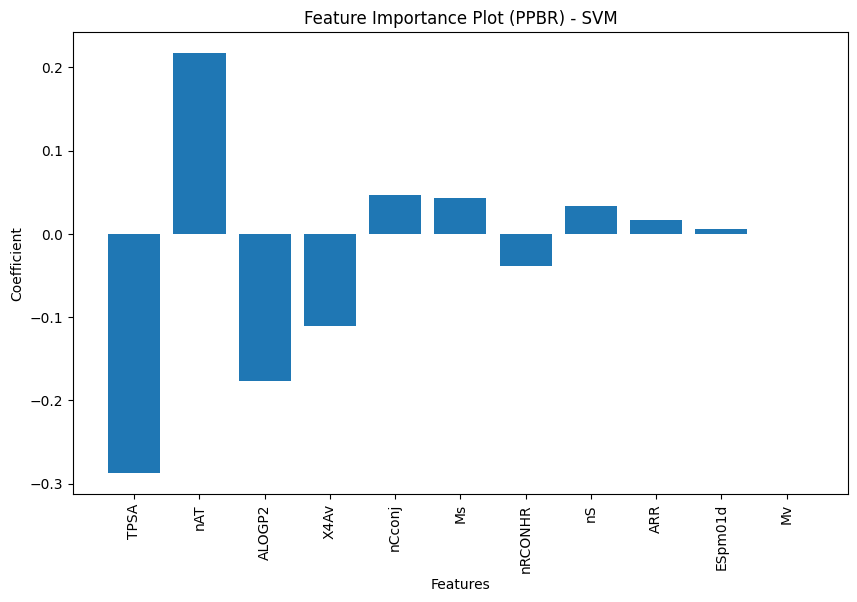

In [ ]:
# Feature Importance Plot

coefficients = svm_classifier_ppbr.coef_[0]

feature_names = ["Mv", "Ms", "nAT", "nS", "ARR", "X4Av", "ESpm01d", "ALOGP2", "TPSA", "nCconj", "nRCONHR"]

sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), sorted_coefficients, tick_label=sorted_feature_names)
plt.title('Feature Importance Plot (PPBR) - SVM')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.show()

BIO

-----

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, cohen_kappa_score, accuracy_score

combined_features_bio = np.vstack((X_scaled_bio, valid_X_scaled_bio))
combined_labels_bio = np.concatenate((split['train']['Y'], split['valid']['Y']))
svm_classifier_bio = SVC(kernel='linear')
cv_scores_bio = cross_val_score(svm_classifier_bio, combined_features_bio, combined_labels_bio, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores_bio)
print("Mean Accuracy:", cv_scores_bio.mean())

Cross-Validation Scores: [0.78640777 0.7961165  0.78431373 0.7745098  0.7745098 ]
Mean Accuracy: 0.7831715210355987


In [ ]:
# Train the model
svm_classifier_bio.fit(combined_features_bio, combined_labels_bio)

SVC(kernel='linear')

In [ ]:
# Evaluate the model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    auc_roc = roc_auc_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    balanced_accuracy = (sensitivity + specificity) / 2
    kappa = cohen_kappa_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    return auc_roc, sensitivity, specificity, balanced_accuracy, kappa, accuracy

In [ ]:
# Evaluate the model on test data
auc_roc_test, sensitivity_test, specificity_test, balanced_accuracy_test, kappa_test, accuracy = evaluate_model(svm_classifier_bio, test_X_scaled_bio, split['test']['Y'])
print("\nTest Performance:")
print("AUC-ROC:", auc_roc_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("Balanced Accuracy:", balanced_accuracy_test)
print("Cohen's Kappa:", kappa_test)
print("Accuracy:", accuracy)


Test Performance:
AUC-ROC: 0.5491228070175439
Sensitivity: 0.9666666666666667
Specificity: 0.13157894736842105
Balanced Accuracy: 0.5491228070175439
Cohen's Kappa: 0.12727272727272732
Accuracy: 0.71875


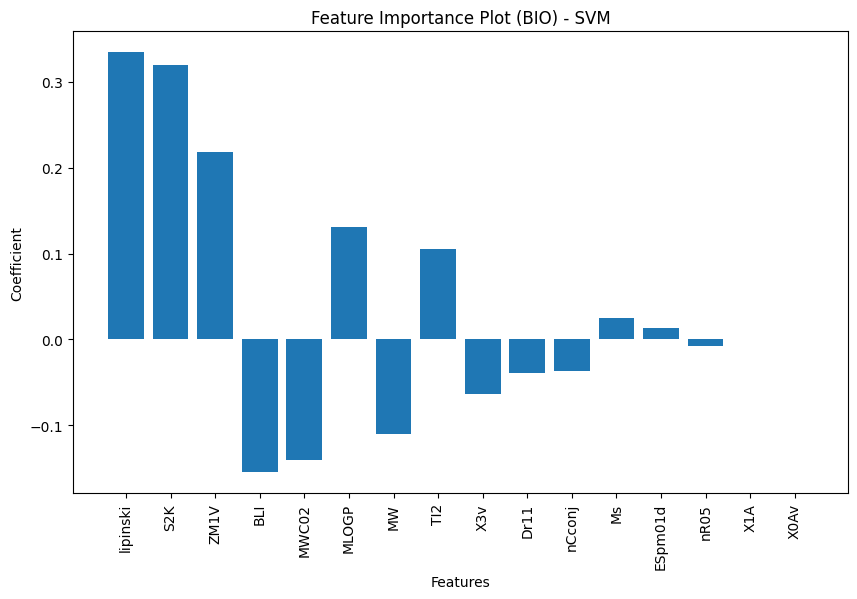

In [ ]:
# Feature Importance Plot

coefficients = svm_classifier_bio.coef_[0]

feature_names = ["MW", "Ms", "nR05", "S2K", "ZM1V", "BLI", "TI2", "Dr11", "X1A", "X0Av", "X3v", "MWC02", "ESpm01d", "MLOGP", "nCconj", "lipinski"]

sorted_coefficients = coefficients[np.argsort(np.abs(coefficients))[::-1]]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), sorted_coefficients, tick_label=sorted_feature_names)
plt.title('Feature Importance Plot (BIO) - SVM')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.show()

Random Forest
---

PPBR

-----

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, cohen_kappa_score, accuracy_score

combined_features_ppbr = np.vstack((X_scaled_ppbr, valid_X_scaled_ppbr))
combined_labels_ppbr = np.concatenate((split['train']['Y'], split['valid']['Y']))
rf_classifier_ppbr = RandomForestClassifier(n_estimators=200)
cv_scores_ppbr = cross_val_score(rf_classifier_ppbr, combined_features_ppbr, combined_labels_ppbr, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_ppbr)
print("Mean Accuracy:", cv_scores_ppbr.mean())

Cross-Validation Scores: [0.75728155 0.81553398 0.76470588 0.7745098  0.81372549]
Mean Accuracy: 0.7851513420902341


In [ ]:
# Train the model
rf_classifier_ppbr.fit(combined_features_ppbr, combined_labels_ppbr)

RandomForestClassifier(n_estimators=200)

In [ ]:
# Evaluate the model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    auc_roc = roc_auc_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    balanced_accuracy = (sensitivity + specificity) / 2
    kappa = cohen_kappa_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    return auc_roc, sensitivity, specificity, balanced_accuracy, kappa, accuracy

In [ ]:
# Evaluate the model on test data
auc_roc_test, sensitivity_test, specificity_test, balanced_accuracy_test, kappa_test, accuracy = evaluate_model(rf_classifier_ppbr, test_X_scaled_ppbr, split['test']['Y'])
print("\nTest Performance:")
print("AUC-ROC:", auc_roc_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("Balanced Accuracy:", balanced_accuracy_test)
print("Cohen's Kappa:", kappa_test)
print("Accuracy:", accuracy)


Test Performance:
AUC-ROC: 0.5587719298245615
Sensitivity: 0.9333333333333333
Specificity: 0.18421052631578946
Balanced Accuracy: 0.5587719298245614
Cohen's Kappa: 0.14512635379061367
Accuracy: 0.7109375


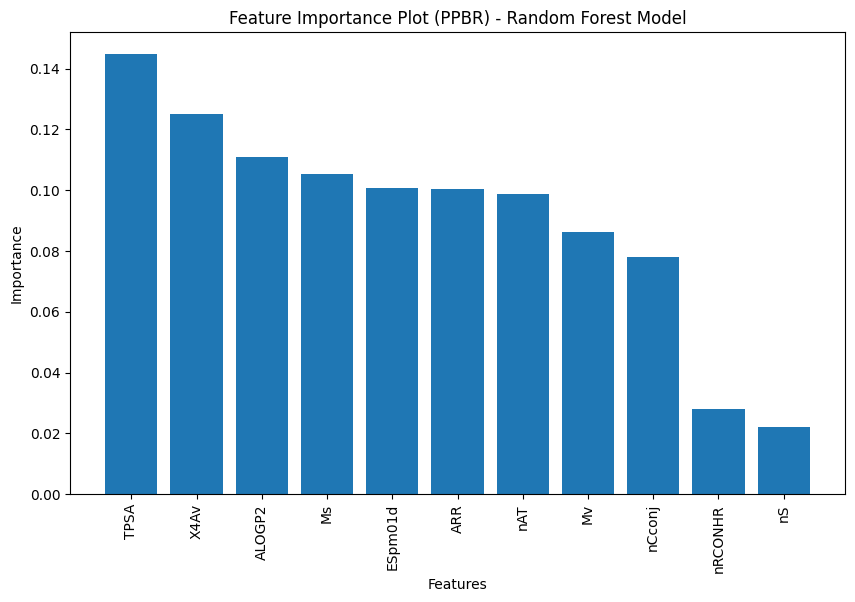

In [ ]:
# Feature Importance Plot

importances = rf_classifier_ppbr.feature_importances_

feature_names = ["Mv", "Ms", "nAT", "nS", "ARR", "X4Av", "ESpm01d", "ALOGP2", "TPSA", "nCconj", "nRCONHR"]

sorted_feature_names = [feature_names[i] for i in importances[importances.argsort()[::-1]]]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), sorted_importances, tick_label=sorted_feature_names)
plt.title('Feature Importance Plot (PPBR) - Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()


BIO

-----

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, cohen_kappa_score, accuracy_score

combined_features_bio = np.vstack((X_scaled_bio, valid_X_scaled_bio))
combined_labels_bio = np.concatenate((split['train']['Y'], split['valid']['Y']))
rf_classifier_bio = RandomForestClassifier(n_estimators=200)
cv_scores_bio = cross_val_score(rf_classifier_bio, combined_features_bio, combined_labels_bio, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_bio)
print("Mean Accuracy:", cv_scores_bio.mean())

Cross-Validation Scores: [0.78640777 0.76699029 0.78431373 0.79411765 0.81372549]
Mean Accuracy: 0.789110984199505


In [ ]:
# Train the model
rf_classifier_bio.fit(combined_features_bio, combined_labels_bio)

RandomForestClassifier(n_estimators=200)

In [ ]:
# Evaluate the model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    auc_roc = roc_auc_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    balanced_accuracy = (sensitivity + specificity) / 2
    kappa = cohen_kappa_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    return auc_roc, sensitivity, specificity, balanced_accuracy, kappa, accuracy

In [ ]:
# Evaluate the model on test data
auc_roc_test, sensitivity_test, specificity_test, balanced_accuracy_test, kappa_test, accuracy = evaluate_model(rf_classifier_bio, test_X_scaled_bio, split['test']['Y'])
print("\nTest Performance:")
print("AUC-ROC:", auc_roc_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("Balanced Accuracy:", balanced_accuracy_test)
print("Cohen's Kappa:", kappa_test)
print("Accuracy:", accuracy)


Test Performance:
AUC-ROC: 0.5587719298245615
Sensitivity: 0.9333333333333333
Specificity: 0.18421052631578946
Balanced Accuracy: 0.5587719298245614
Cohen's Kappa: 0.14512635379061367
Accuracy: 0.7109375


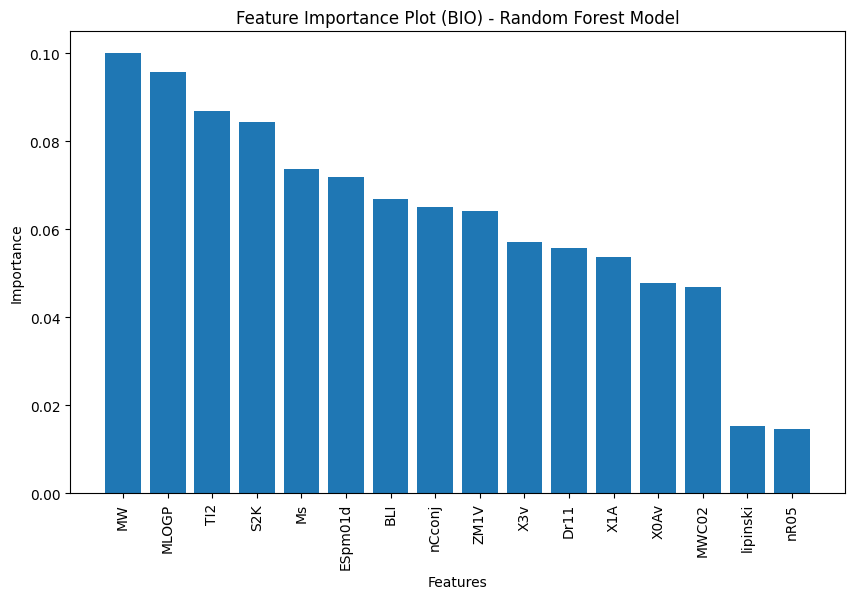

In [ ]:
# Feature Importance Plot

importances = rf_classifier_bio.feature_importances_

feature_names = ["MW", "Ms", "nR05", "S2K", "ZM1V", "BLI", "TI2", "Dr11", "X1A", "X0Av", "X3v", "MWC02", "ESpm01d", "MLOGP", "nCconj", "lipinski"]

sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), sorted_importances, tick_label=sorted_feature_names)
plt.title('Feature Importance Plot (BIO) - Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()


GNN

Embeddings using SMILE and Features

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.8.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.8.0+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.8.0+cpu.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.8.0+cpu.html
!pip install torch-geometric

In [ ]:
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
import torch
import torch.nn as nn
from torch.optim import Adam

# https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/
# https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/smiles.html
# https://medium.com/@JyotsnaPyarasani/building-a-senolytic-prediction-model-using-graph-neural-networks-7e244db3101c

def smiles_to_graph(smiles, descriptors):
    m = Chem.MolFromSmiles(smiles)
    node_features = []
    for atom in m.GetAtoms():
        node_features.append(atom.GetAtomicNum())
    node_features = torch.tensor(node_features, dtype=torch.float).unsqueeze(-1)
    edges = []
    for bond in m.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        edges.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    data = Data(x=node_features, edge_index=edge_index, descriptors=torch.tensor(descriptors, dtype=torch.float))
    return data

### PPBR

In [ ]:
import torch
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(1, 30)
        self.conv2 = GCNConv(30, 50)
        self.fc1 = torch.nn.Linear(60, 30) # be sure to add the number of features which you extracted - so in this case 50 + extracted features = 60
        self.fc2 = torch.nn.Linear(30, 2)

    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = torch.relu(x)
        x = self.conv2(x, data.edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, data.batch)
        x = torch.cat([x, data.descriptors], dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
train_labels = torch.tensor(split['train']['Y'], dtype=torch.long)
train_features = []
for smiles in split['train']['Drug']:
    features = feature_gen_ppbr_single(smiles)
    train_features.append(features)

train_data = []
for smiles, features in zip(split['train']['Drug'], train_features):
    graph_data = smiles_to_graph(smiles, features)
    train_data.append(graph_data)

In [ ]:
model = GNN()
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(1000):
    model.train()
    total_loss = 0
    for data, label in zip(train_data, train_labels):
        optimizer.zero_grad()
        output = model(data)
        label = torch.tensor([label], dtype=torch.long)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    curr_loss = total_loss / len(train_data)
    print(epoch, curr_loss)

In [ ]:
test_labels = torch.tensor(split['test']['Y'], dtype=torch.long)
test_features = []
for smiles in split['test']['Drug']:
    features = feature_gen_ppbr_single(smiles)
    test_features.append(features)

test_data = []
for smiles, features in zip(split['test']['Drug'], test_features):
    graph_data = smiles_to_graph(smiles, features)
    test_data.append(graph_data)

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for data in test_data:
        output = model(data)
        predictions.append(output.argmax(dim=1))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
accuracy = accuracy_score(test_labels, predictions)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("f1:", f1)

In [ ]:
def evaluate_model_gnn(model, X, y_pred):
    y = split['test']['Y']
    auc_roc = roc_auc_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    balanced_accuracy = (sensitivity + specificity) / 2
    kappa = cohen_kappa_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    return auc_roc, sensitivity, specificity, balanced_accuracy, kappa, accuracy

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, cohen_kappa_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

auc_roc_test, sensitivity_test, specificity_test, balanced_accuracy_test, kappa_test, accuracy = evaluate_model_gnn(model, test_labels, predictions)
print("\nTest Performance:")
print("AUC-ROC:", auc_roc_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("Balanced Accuracy:", balanced_accuracy_test)
print("Cohen's Kappa:", kappa_test)
print("Accuracy:", accuracy)

### BIO

In [ ]:
import torch
from torch_geometric.nn import GCNConv, global_mean_pool

class GNNB(torch.nn.Module):
    def __init__(self):
        super(GNNB, self).__init__()
        self.conv1 = GCNConv(1, 30)
        self.conv2 = GCNConv(30, 50)
        self.fc1 = torch.nn.Linear(66, 30) # be sure to add the number of features which you extracted - so in this case 50 + extracted features = 60
        self.fc2 = torch.nn.Linear(30, 2)

    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        # print(x)
        x = torch.relu(x)
        x = self.conv2(x, data.edge_index)
        # print(x)
        x = torch.relu(x)
        # print(x.shape)
        # print(data.descriptors.shape)
        x = global_mean_pool(x, data.batch)
        x = torch.cat([x, data.descriptors], dim=1)
        x = self.fc1(x)
        # print(x)
        x = torch.relu(x)
        x = self.fc2(x)
        # print(x)
        return x

In [ ]:
train_features = []
for smiles in split['train']['Drug']:
    train_features.append(feature_gen_bio_single(smiles))

train_data = []
for smiles, features in zip(split['train']['Drug'], train_features):
    train_data.append(smiles_to_graph(smiles, features))
train_labels = torch.tensor(split['train']['Y'], dtype=torch.long)


In [ ]:
print(train_data[0].x.shape)
print(train_data[0].edge_index.shape)
print(train_data[0].batch)
print(train_data[0].descriptors.shape)

In [ ]:
model = GNNB()
optimizer = Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(1000):
    model.train()
    total_loss = 0
    for data, label in zip(train_data, train_labels):
        optimizer.zero_grad()
        output = model(data)
        # print(output)
        label = torch.tensor([label], dtype=torch.long)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    curr_loss = total_loss / len(train_data)
    print(epoch, curr_loss)

In [ ]:
test_features = []
for smiles in split['test']['Drug']:
    features = feature_gen_bio_single(smiles)
    test_features.append(features)

test_data = []
for smiles, features in zip(split['test']['Drug'], test_features):
    graph_data = smiles_to_graph(smiles, features)
    test_data.append(graph_data)

In [ ]:
model.eval()
predictions = []
with torch.no_grad():
    for data in test_data:
        output = model(data)
        predictions.append(output.argmax(dim=1))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
accuracy = accuracy_score(test_labels, predictions)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("f1:", f1)

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, cohen_kappa_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

auc_roc_test, sensitivity_test, specificity_test, balanced_accuracy_test, kappa_test, accuracy = evaluate_model_gnn(model, test_labels, predictions)
print("\nTest Performance:")
print("AUC-ROC:", auc_roc_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("Balanced Accuracy:", balanced_accuracy_test)
print("Cohen's Kappa:", kappa_test)
print("Accuracy:", accuracy)